# LANL Earthquake Prediction

The goal of this project is to use seismic signals to predict the timing of laboratory earthquakes. The data is produced by an experimental set-up used to study earthquake physics. The acoustic_data input signal is used to predict the time remaining before the next laboratory earthquake (time_to_failure). For the initial analysis, we explore the data features and decide on the best model to be used to solve this problem. Additional insight into the trends of the earthquakes can introduce better pre-processing strategies which will be taken initially to increase training time. Ensure the data are download to the same directory as this Notebook for the next data loading steps.

In [1]:
import pandas as pd

# sample submissions
sample_output = pd.read_csv('sample_submission.csv', sep=",")
sample_output.head()

,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


In [2]:
# data types for each col
print(sample_output.dtypes)

seg_id             object
time_to_failure     int64
dtype: object


## Loading and exploring train data
Column names on the train.csv file and corresponding data types:

In [3]:
from DataGen import DataGen
train_data_generator = DataGen(file_path='train.csv', chunk_size=10000000)
print(train_data_generator.col_names)
print('------------------------------------')

next_batch, end_of_file = train_data_generator.next_batch()

print('Duplicates in "time_to_failure"? {}'.format(
    not next_batch.loc[next_batch['time_to_failure'].duplicated()].empty))

next_batch.head()

['acoustic_data', 'time_to_failure']
------------------------------------
Duplicates in "time_to_failure"? False


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [4]:
# data types for each col
print(next_batch.dtypes)
print('------------------------------------')
print('Duplicates in "time_to_failure"? {}'.format(
    not next_batch.loc[next_batch['time_to_failure'].duplicated()].empty))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

acoustic_data        int64
time_to_failure    float64
dtype: object
------------------------------------
Duplicates in "time_to_failure"? False


### Plot second batch of data and zoom in

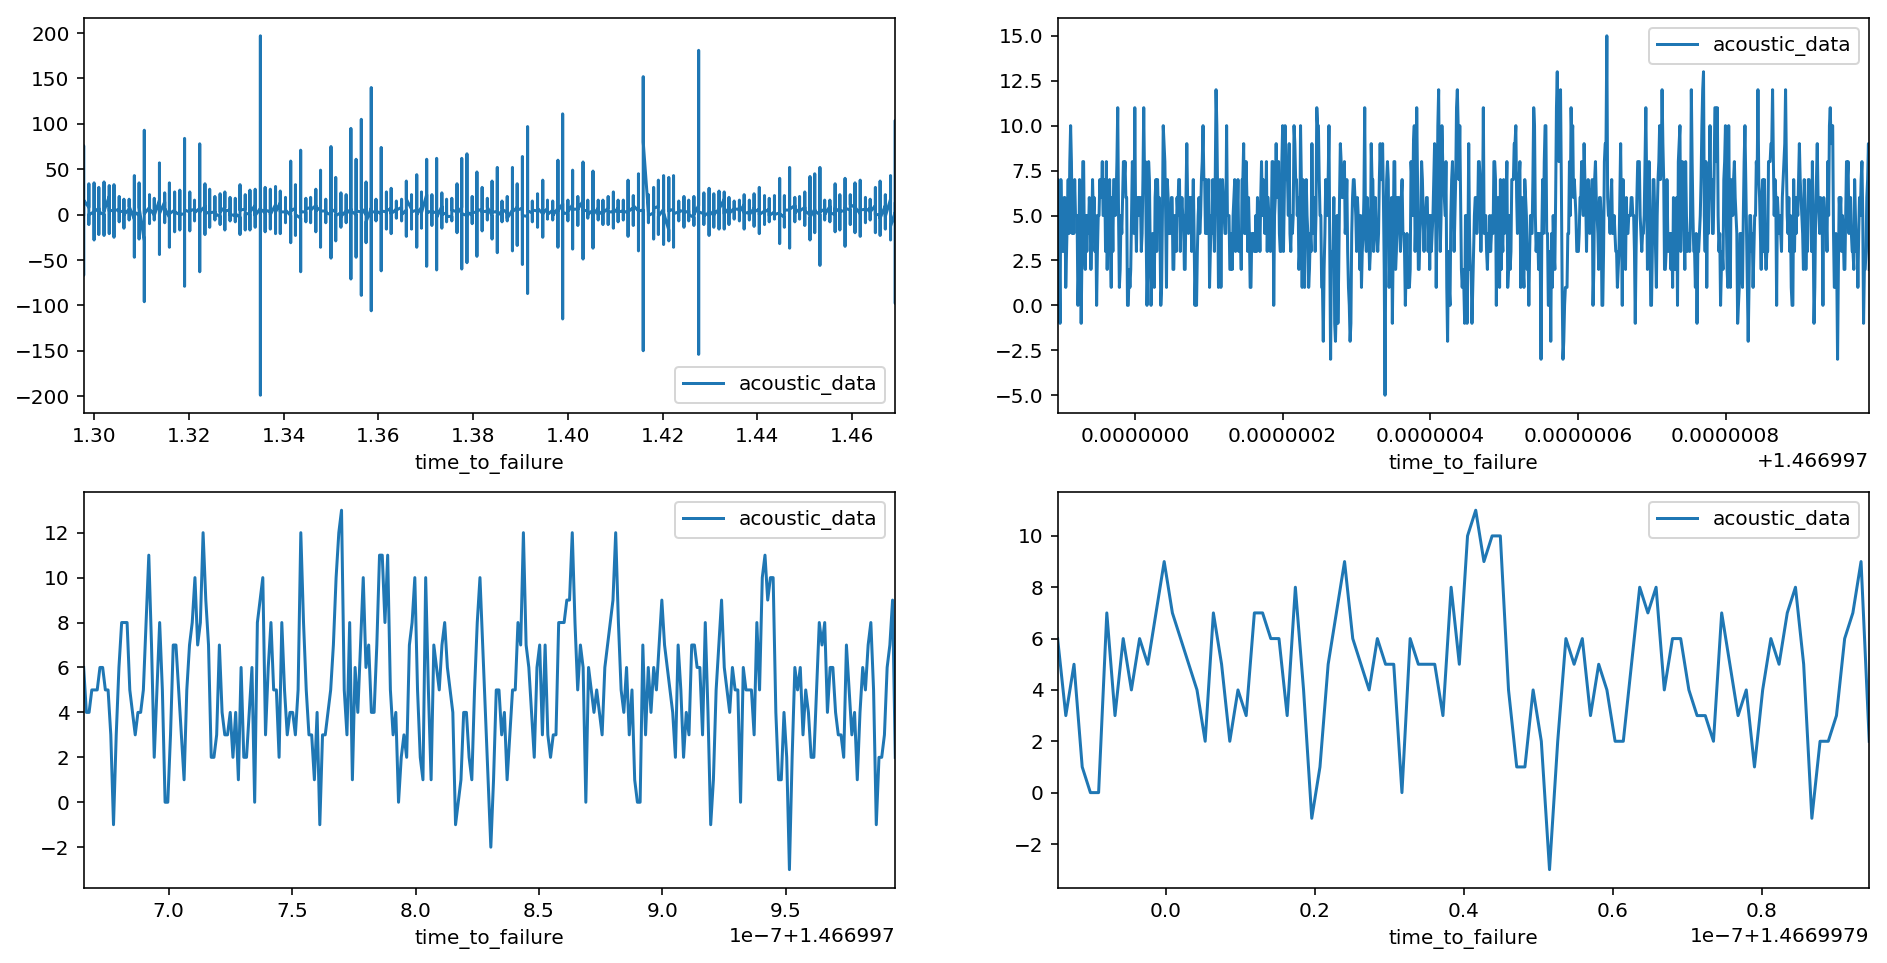

In [5]:
# plot second batch of data
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
next_batch.plot(x='time_to_failure', y='acoustic_data', ax=axs[0, 0])
next_batch[10000:11000].plot(x='time_to_failure', y='acoustic_data', ax=axs[0, 1])
next_batch[10000:10300].plot(x='time_to_failure', y='acoustic_data', ax=axs[1, 0])
next_batch[10000:10100].plot(x='time_to_failure', y='acoustic_data', ax=axs[1, 1])

We have coarse sinosoidal data as acoustic_data with a good small integer range but since it is 64 bit int, it can be further optimized if min/max values are found. The time data is very coarse float type and can further be rescaled to optimized integers for more efficient computations. Initially the data will be condensed for more optimized computations using fourier decomposition of the sinosoidal data.

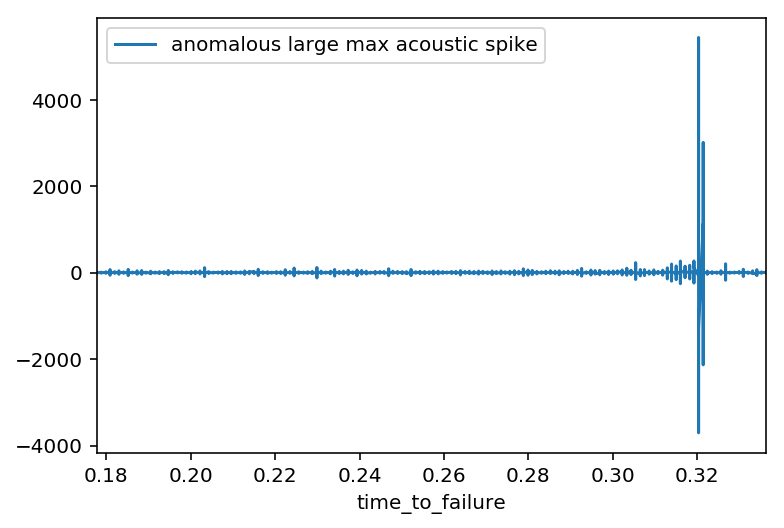

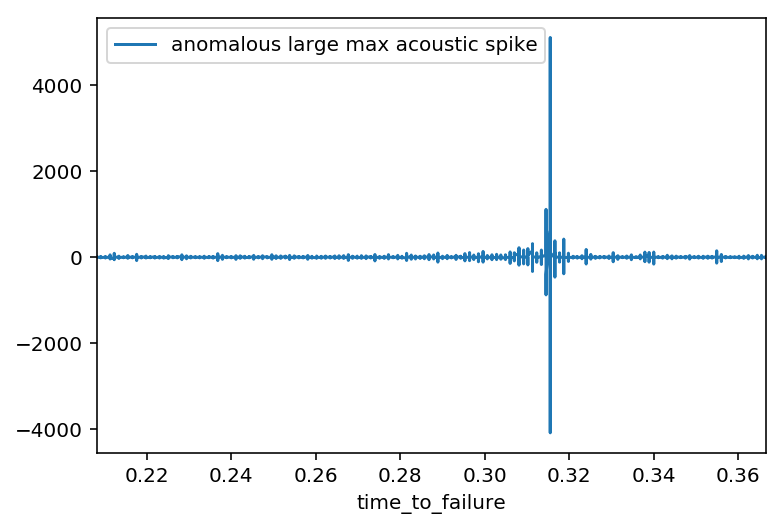

In [6]:
if next_batch.empty:
    train_data_generator = DataGen(file_path='train.csv', chunk_size=10000000)
    next_batch, end_of_file = train_data_generator.next_batch()

maxx = next_batch.max(axis=0)
minn = next_batch.min(axis=0)
summ = next_batch.sum(axis=0)
max_acoustic = maxx[0]
sum_acoustic = summ[0]
min_acoustic = minn[0]
max_time = maxx[1]
sum_time = summ[1]
min_time = minn[1]
data_points = next_batch.shape[0]
while True:
    maxx = next_batch.max(axis=0)
    minn = next_batch.min(axis=0)
    if maxx[0] > 5000.0:
        next_batch.plot(x='time_to_failure', y='acoustic_data', label='anomalous large max acoustic spike')
    if maxx[0] > max_acoustic:
        max_acoustic = maxx[0]
    if minn[0] < min_acoustic:
        min_acoustic = minn[0]
    if maxx[1] > max_time:
        max_time = maxx[1]
    if minn[1] < min_time:
        min_time = minn[1]

    next_batch, end_of_file = train_data_generator.next_batch()
    if end_of_file:
        break
    data_points += next_batch.shape[0]
    summ = next_batch.sum(axis=0)
    sum_acoustic += summ[0]
    sum_time += summ[1]

In [8]:
{
    'max_acoustic': max_acoustic, 'min_acoustic': min_acoustic, 'max_time': max_time, 'min_time': min_time,
    'avg_acoustic': sum_acoustic / data_points, 'ave_time': sum_time / data_points
}

{'max_acoustic': 5444.0,
 'min_acoustic': -5515.0,
 'max_time': 16.1074,
 'min_time': 9.550396316600001e-05,
 'avg_acoustic': 4.519467573700124,
 'ave_time': 5.678291712978873}

# Data Extremeties
There appears to be big spikes that could be important for predicting the time of event, the ultimate prediction for this project. First attempts to pre-process the data would be to decompose into fourier space frequency distributions. Data can then be broken into smaller chucnks to be used for further pattern recognition. Recent advances in Continuous Wave-let Transforms show better resolution when using wavelets given by a frequency dependent window size [1]. The scaled and modulated windows used is described below and helps bring better resolution from both low and high frequency modulations into consideration when 

[1]:  ”Spectral decomposition of seismic data with continuous-wavelet transform.” GEOPHYSICS, 70(6), P19-P25. *J. P. Catagna et al... 2005*



In [104]:
from IPython.display import Latex

Latex(r"""We choose a the Morlet wavelet as our window such that
\begin{eqnarray}
\psi_{\sigma}(t) = \pi^{-1/4}C_{\psi}e^{-t^{2}/2} (e^{i\omega_{0} t} - e^{-\sigma^{2}/2})
\end{eqnarray}
and given some input signal $f(t)$ our time-scale map is:
\begin{eqnarray}
F_{W} (\sigma, \tau) = \langle f(t), \psi_{\sigma, \tau}(t) \rangle.
\end{eqnarray}
And the fundumental equation used to calculate our wavelets is:
\begin{eqnarray}
\hat{f} (\omega, \tau) = \frac{1}{C_\psi} \int^{\infty}_{-\infty} F_{W} (\sigma, \tau) \hat{\psi}(\sigma\omega)
e^{-i\omega t}\frac{d \sigma}{\sigma^{3/2}}.
\end{eqnarray}
Where the wavelet admissibility condition leads to
\begin{eqnarray}
C_{\psi} = 2\pi \int^{\infty}_{-\infty} \frac{|\hat{\psi}|^{2}}{\omega}d\omega < \infty
\end{eqnarray}
We take sigma to be $\sigma<5$ for events with high variation in frequency and $\sigma>5$ for audio signals. 
3 windows will be used initially and windows sizes must follow in a similar fashion to $\sigma$.""")

<IPython.core.display.Latex object>

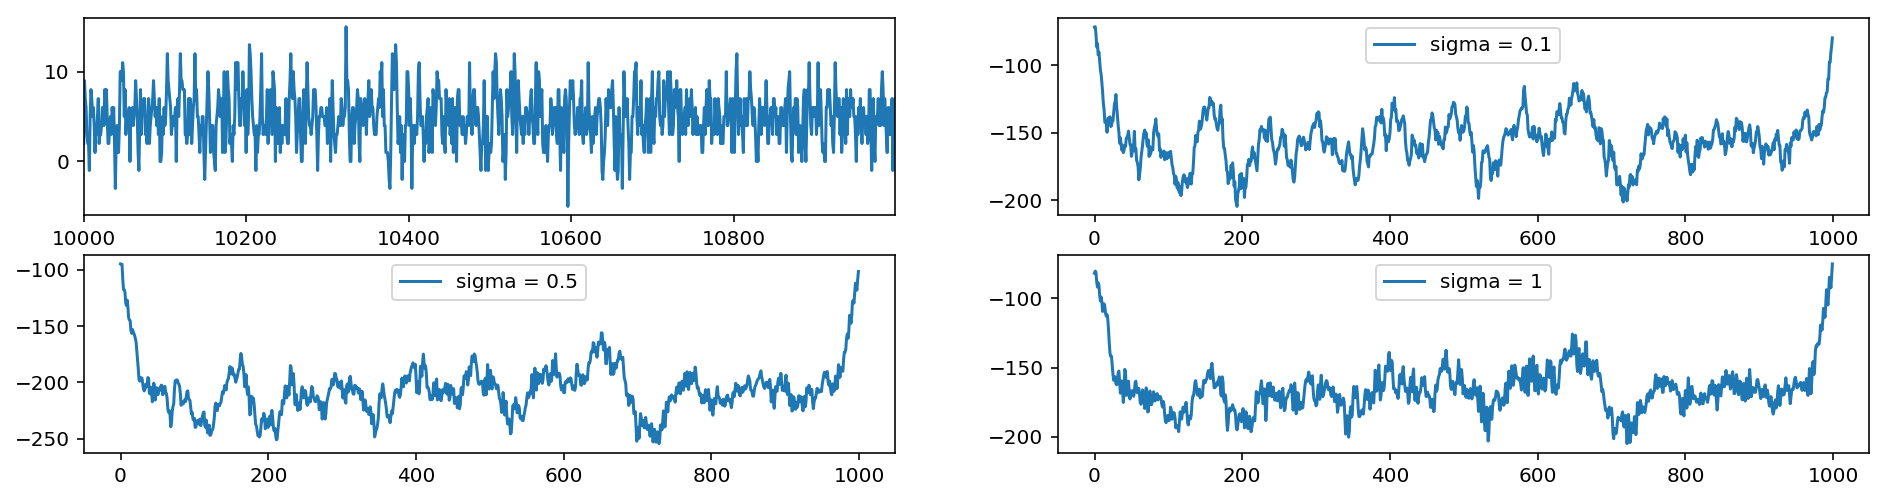

In [108]:
import matplotlib.pyplot as plt
from scipy import signal
from math import pi, e
from DataGen import DataGen

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, axs = plt.subplots(2, 2, figsize=(16, 4))
train_data_generator = DataGen(file_path='train.csv', chunk_size=10000000)
next_batch, end_of_file = train_data_generator.next_batch()
current_batch = next_batch['acoustic_data'][10000:11000]
current_batch.plot(x='time_to_failure', y='acoustic_data', ax=axs[0, 0])

sigma = [0.1, 0.5, 1]
t = M = [32, 48, 56] # windows sizes
w = 2*pi # Omega0 - base angular freq

sigma_term = e**(-(sigma[0]**2)/2)
morlet = signal.morlet(t[0], w=2*pi)
F_W = signal.fftconvolve(current_batch, morlet - sigma_term, mode='same')
axs[0, 1].plot(F_W, label="sigma = {}".format(sigma[0]))
axs[0, 1].legend()

sigma_term = e**(-(sigma[1]**2)/2)
morlet = signal.morlet(t[1], w=2*pi)
F_W = signal.fftconvolve(current_batch, morlet - sigma_term, mode='same')
axs[1, 0].plot(F_W, label="sigma = {}".format(sigma[1]))
axs[1, 0].legend()

sigma_term = e**(-(sigma[2]**2)/2)
morlet = signal.morlet(t[2], w=2*pi)
F_W = signal.fftconvolve(current_batch, morlet - sigma_term, mode='same')
axs[1, 1].plot(F_W, label="sigma = {}".format(sigma[2]))
axs[1, 1].legend()

There is a good visual symmetry between each graph and so the decomposition is taking place with good agreement. Additional steps to reduce the noise introduced is to trim the egdges introduced by the kernel profile and renormalize to a positive small integer.

In [115]:
import numpy as np
def preprocess(current_batch):
    f = np.ndarray(shape=(3,), dtype=np.int16)
    for i in range(len((sigma))):
        sigma_term = e**(-(sigma[i]**2)/2)
        morlet = signal.morlet(t[i], w=2*pi)
        C_psi = 2 * pi * signal.correlate(np.fft.fft(current_batch), np.conj(np.fft.fft(current_batch)), mode='full').sum()
        F_W = signal.fftconvolve(current_batch, morlet - sigma_term, mode='same')
        F_W = np.dot(F_W[100:900], F_W[100:900]).real / C_psi.real
        f[i] = int(F_W * 100)
    return f

# Model examination
Now we can attempt training a good time-series candidate model for seq-to-num to attempt predicting time to event.

In [117]:
train_data_generator = DataGen(file_path='train.csv', chunk_size=10000000)
sum_time = 0
while True:
    next_batch, end_of_file = train_data_generator.next_batch()
    if end_of_file:
        break
    data_points = next_batch.shape[0]
    maxx = next_batch.max(axis=0)
    minn = next_batch.min(axis=0)
    summ = next_batch.sum(axis=0)
    max_time = maxx[1]
    sum_time += summ[1]
    min_time = minn[1]
    preprocess()

[ 79 140  90]
